In [1]:
import sys ; sys.path.append('../')
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *
import torch ; import torch.utils.data as data
import pytorch_lightning as pl ; from pytorch_lightning.loggers import WandbLogger
from src import *

import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load `torchdyn`'s FFJORD model

In [2]:
hdim = 128
s_span = torch.linspace(1, 0, 2)
f = nn.Sequential(
        nn.Linear(2, hdim),
        nn.Softplus(),
        nn.Linear(hdim, hdim),
        nn.Softplus(),
        nn.Linear(hdim, hdim),
        nn.Softplus(),
        nn.Linear(hdim, hdim),
        nn.Tanh(),
        nn.Linear(hdim, 2))

cnf = CNF(f, trace_estimator=autograd_trace)
nde = NeuralDE(cnf, solver='dopri5', s_span=s_span, sensitivity='adjoint', atol=1e-8, rtol=1e-8)
model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1), nde).to(device)
#
dummy_out = model(torch.randn(10, 2).to(device))

In [3]:
model.load_state_dict(torch.load('../pretrained_models/ffjord_gaussians'))

<All keys matched successfully>

## Hypersolver

In [4]:
hdim = 64
g  = nn.Sequential(
    nn.Linear(13, hdim, bias=True),
    nn.PReLU(),
    nn.Linear(hdim, hdim, bias=True),
    nn.PReLU(),
    nn.Linear(hdim, 3, bias=True)
).to(device)
for p in g[-1].parameters(): torch.nn.init.zeros_(p)

hsolver = HyperHeun(model[1].defunc, g).to(device)
s_span = torch.Tensor([0, 1])

In [5]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical
prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

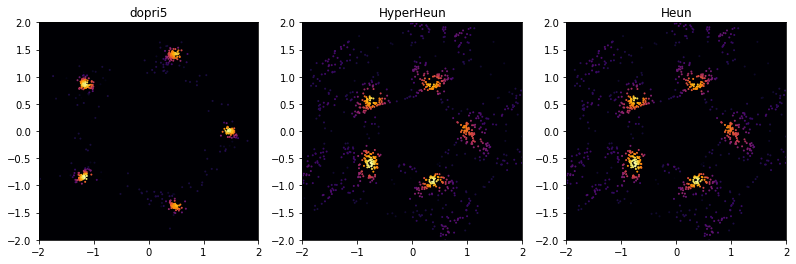

In [6]:
plot_ffjord(model, hsolver, prior, 0, show=True)
model, hsolver = model.to(device), hsolver.to(device)

## Train HyperHeun 

In [7]:
# dummy trainloader
trainloader = data.DataLoader(data.TensorDataset(torch.Tensor(1).to(device), torch.Tensor(1).to(device)), batch_size=1024, shuffle=True) 

# learner
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, hsolver:nn.Module):
        super().__init__()
        self.model, self.hsolver = model, hsolver
        self.iters = 0
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.iters += 1
        x = prior.sample(torch.Size([1 << 8])) ; logpx = prior.log_prob(x)[:,None].to(x)
        xtrJ = torch.cat([logpx, x], 1)
        dopri_traj = model[1].trajectory(xtrJ, s_span).detach()
        solver_traj = hsolver.trajectory(xtrJ.detach(), s_span)
        loss = torch.norm(solver_traj - dopri_traj.detach(), p=1, dim=2).mean() 
        logs = {'train loss': loss,}
        nde.nfe = 0
        if not self.iters%100:
            plot_ffjord(self.model, self.hsolver, prior, self.iters)
            self.model, self.hsolver = self.model.to(device), self.hsolver.to(device)
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.hsolver.parameters(), lr=5e-3, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=3000, eta_min=5e-4)
        return [opt], [scheduler]
    def train_dataloader(self):
        return trainloader

In [ ]:
logger = WandbLogger(project='Hypersolver-FFJORD', name='HyperHeun')
learn = Learner(model, hsolver)
trainer = pl.Trainer(max_epochs=3000, gradient_clip_val=0.5, logger=logger)
trainer.fit(learn);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

  | Name    | Type       | Params
---------------------------------------
0 | model   | Sequential | 50 K  
1 | hsolver | HyperHeun  | 55 K  


C:\Users\Stefano\anaconda3\lib\site-packages\torchdiffeq\_impl\misc.py:237: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


In [ ]:
plot_ffjord(model, hsolver, prior, 0, show=True)
model, hsolver = model.to(device), hsolver.to(device)